In [3]:
import os
import json
import sys
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.utilities.model_summary import ModelSummary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_module.data_module import ALDataModule_v1, FFTDataModule
from model.classifier_model import Classifier1D
from utils.data_utils import limit_filter_data_by_class
from utils.model_utils import reset_weight_model


In [4]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('-ck', "--checkpoint_path", type=str, default="/nfs/ksdata/tran/HAR_AE/lightning_logs/10.3_classify_8classes_10000data/version_4/checkpoints/sample_epoch=19639-step=78560-val_loss=0.385121.ckpt", 
                    help=f"AL learning model checkpoint. If you do not have any ckpt of model. You should consider running classifier notebook to create one")

parser.add_argument('-m', "--method", type=str, default="sampling",
                    help=f":: select run method from [random, sampling, full]")

parser.add_argument("-sh", "--sampling_heuristic", type=str, default="uncertainty",
                    help=f"""heuristic function in case the method is sampling:: [uncertainty, entropy, margin],
                    ref: https://github.com/baal-org/baal/blob/master/baal/active/heuristics/heuristics.py#L512""")

parser.add_argument("-ss", "--sampling_size", type=int, default=500,
                    help=f"sampler size to take from additional dataset. normally < 5000, Not effective for method `full`")

parser.add_argument("-tl", "--train_limit_data", type=int, default=1000,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("--filter_unselected_data_num", type=int, default=5000,
                    help=f"Used for get the size of additional dataset")

parser.add_argument("--reset_weight", type=int, default=0,
                    help=f"Reset weight before training. If not reset, we will continue learning from the checkpoint")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [9]:
args.eval_mode = 1

In [10]:
n_epochs = 20000
patience = n_epochs//100

optimizer_param_dict = {
    "Adam": (optim.Adam, {
        "lr": 0.001,
    }),
    "SGD": (optim.SGD, {
        "lr": 0.001,
        "momentum": 0.5,
    }),
}
optimizer, optimizer_param = optimizer_param_dict["Adam"]

log_save_dir = "lightning_logs"

reset_str = "_reset" if args.reset_weight else ""
    
log_save_name = f"16.1_AL_v2{reset_str}/{args.method}_{args.sampling_heuristic}_{args.sampling_size}"

In [11]:
net = Classifier1D.load_from_checkpoint(args.checkpoint_path)

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes     | Out sizes   
------------------------------------------------------------------------
0  | cnn      | Sequential  | 18.0 K | [10, 6, 257] | [10, 64, 26]
1  | cnn.0    | Conv1d      | 1.6 K  | [10, 6, 257] | [10, 32, 84]
2  | cnn.1    | ReLU        | 0      | [10, 32, 84] | [10, 32, 84]
3  | cnn.2    | Dropout     | 0      | [10, 32, 84] | [10, 32, 84]
4  | cnn.3    | Conv1d      | 16.4 K | [10, 32, 84] | [10, 64, 26]
5  | cnn.4    | ReLU        | 0      | [10, 64, 26] | [10, 64, 26]
6  | cnn.5    | Dropout     | 0      | [10, 64, 26] | [10, 64, 26]
7  | linear   | Sequential  | 460 K  | [10, 1664]   | [10, 8]     
8  | linear.0 | Linear      | 426 K  | [10, 1664]   | [10, 256]   
9  | linear.1 | BatchNorm1d | 512    | [10, 256]    | [10, 256]   
10 | linear.2 | ReLU        | 0      | [10, 256]    | [10, 256]   
11 | linear.3 | Linear      | 32.9 K | [10, 256]    | [10, 128]   
12 | linear.4 | BatchNorm1d | 256    | [10, 128]    | [1

In [6]:
def process_tl_and_additional_ds(data_module):
    assert args.train_limit_data + args.filter_unselected_data_num < np.max(np.unique(data_module._train_label, return_counts=True)[1])
    
    data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
    
    unselected_train_idx = list(set(range(len(data_module._train_label))) - set(data_module.choice_limited_list))
    unselected_train_data = data_module._train_data[unselected_train_idx]
    unselected_train_label = data_module._train_label[unselected_train_idx]

    filter_data, filter_label, choice_idx = limit_filter_data_by_class(unselected_train_data, unselected_train_label, args.filter_unselected_data_num)
    return filter_data, filter_label, choice_idx
    

In [ ]:
assert args.method in [ "sampling",  "random",  "full"  ]

if args.method == "sampling":
    # Add to training dataset the uncertainty data for later training
    trainer = L.Trainer()
    
    data_module = ALDataModule_v1.load_from_checkpoint(args.checkpoint_path, prefix="torso_", postfix="_fft", sampler_heuristic=args.sampling_heuristic, sampler_size=args.sampling_size)
    _additional_data, _additional_label, _additional_choice_idx = process_tl_and_additional_ds(data_module)
    
    data_module.set_train_val_test_pred_data(pred_data=_additional_data)
    output = trainer.predict(model=net, datamodule=data_module)
    
    data_module.set_unsertainty_set(data=_additional_data, label=_additional_label, net_output=output)

elif args.method == "random":
    data_module = ALDataModule_v1.load_from_checkpoint(args.checkpoint_path, prefix="torso_", postfix="_fft", sampler_size=args.sampling_size)
    _additional_data, _additional_label, _additional_choice_idx = process_tl_and_additional_ds(data_module)
    
    data_module.set_random_set(data=_additional_data, label=_additional_label)
    
elif args.method == "full":
    data_module = ALDataModule_v1.load_from_checkpoint(args.checkpoint_path, prefix="torso_", postfix="_fft")
    _additional_data, _additional_label, _additional_choice_idx = process_tl_and_additional_ds(data_module)
    
    data_module.set_train_concat_set(data=_additional_data, label=_additional_label)

In [ ]:
## Reset net weight before training
if args.reset_weight:
    reset_weight_model(net, verbose=1)

In [ ]:
if not args.eval_mode:
    print(" ----------------------start training---------------------------")
    from lightning.pytorch.callbacks.early_stopping import EarlyStopping
    from lightning.pytorch.callbacks import ModelCheckpoint
    from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
    
    tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
    csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
    checkpoint_callback = ModelCheckpoint(
        dirpath=None,
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
    )
    
    trainer = L.Trainer(
        logger=[tensorboard_logger, csv_logger],
        callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
        max_epochs=n_epochs,
        check_val_every_n_epoch=10,
        accelerator="gpu", 
        devices=4, 
        strategy="ddp"
        )
    
    trainer.fit(model=net, datamodule=data_module)
    trainer_test_dict = trainer.logged_metrics
    
    trainer.test(model=net, datamodule=data_module)
    trainer_test_dict.update(trainer.logged_metrics)
    
    for key in trainer_test_dict.keys():
        trainer_test_dict[key] = trainer_test_dict[key].item()
    
    with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
        json.dump(trainer_test_dict, f, indent=4)
    
    with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
        json.dump(args.__dict__, f, indent=4)

In [31]:
if args.eval_mode:
    net = Classifier1D.load_from_checkpoint(args.checkpoint_path)
    data_module = ALDataModule_v1.load_from_checkpoint(args.checkpoint_path)
    data_module.set_normal_train()
    
    trainer = L.Trainer()
    trainer.test(model=net, datamodule=data_module)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 139.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.848519504070282
        test_loss           0.4194597601890564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4194597601890564, 'test_acc': 0.848519504070282}]

In [47]:
if args.eval_mode:
    reset_str = ""
    lightning_save_dir = f"lightning_logs/16.1_AL_v2{reset_str}"
    result_save_dict = {}

    for args.method in ["random", "sampling", "full"]:
        if args.method == "random":
            heuristic_list = ["uncertainty"]
            sampling_size_list = [50, 100, 200, 300, 500, 1000]
            
        elif args.method == "full":
            heuristic_list = ["uncertainty"]
            sampling_size_list = [500]
            
        else:
            heuristic_list = ["uncertainty", "entropy", "margin"]
            sampling_size_list = [50, 100, 200, 300, 500, 1000]
        
        for args.sampling_heuristic in heuristic_list:
                
            for args.sampling_size in sampling_size_list:
                save_model_folder = f"{args.method}_{args.sampling_heuristic}_{args.sampling_size}"
                save_model_dir = os.path.join(lightning_save_dir, save_model_folder)
                
                weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                print(save_model_folder, weight)

                net = Classifier1D.load_from_checkpoint(weight)
                data_module = ALDataModule_v1.load_from_checkpoint(weight)
                data_module.set_normal_train()

                trainer = L.Trainer()
                trainer.test(model=net, datamodule=data_module, verbose=False)
                test_acc = trainer.logged_metrics["test_acc"]

                result_save_dict[save_model_folder] = test_acc

result_save_dict


random_uncertainty_50 lightning_logs/16.1_AL_v2/random_uncertainty_50/version_0/checkpoints/sample_epoch=8239-step=255440-val_loss=0.297468.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 129.00it/s]
random_uncertainty_100 lightning_logs/16.1_AL_v2/random_uncertainty_100/version_0/checkpoints/sample_epoch=9769-step=302870-val_loss=0.294510.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 111.87it/s]
random_uncertainty_200 lightning_logs/16.1_AL_v2/random_uncertainty_200/version_0/checkpoints/sample_epoch=13179-step=408580-val_loss=0.285991.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 109.23it/s]
random_uncertainty_300 lightning_logs/16.1_AL_v2/random_uncertainty_300/version_0/checkpoints/sample_epoch=10509-step=325810-val_loss=0.289064.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|████████████████████████████████████| 16/16 [00:00<00:00, 36.39it/s]
random_uncertainty_500 lightning_logs/16.1_AL_v2/random_uncertainty_500/version_0/checkpoints/sample_epoch=16099-step=499100-val_loss=0.283255.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 167.69it/s]
random_uncertainty_1000 lightning_logs/16.1_AL_v2/random_uncertainty_1000/version_0/checkpoints/sample_epoch=9549-step=305600-val_loss=0.292356.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 164.47it/s]
sampling_uncertainty_50 lightning_logs/16.1_AL_v2/sampling_uncertainty_50/version_0/checkpoints/sample_epoch=10259-step=318060-val_loss=0.291381.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 166.02it/s]
sampling_uncertainty_100 lightning_logs/16.1_AL_v2/sampling_uncertainty_100/version_0/checkpoints/sample_epoch=9059-step=280860-val_loss=0.294478.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 165.78it/s]
sampling_uncertainty_200 lightning_logs/16.1_AL_v2/sampling_uncertainty_200/version_0/checkpoints/sample_epoch=14469-step=448570-val_loss=0.286280.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 156.98it/s]
sampling_uncertainty_300 lightning_logs/16.1_AL_v2/sampling_uncertainty_300/version_0/checkpoints/sample_epoch=12359-step=383160-val_loss=0.285717.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 161.71it/s]
sampling_uncertainty_500 lightning_logs/16.1_AL_v2/sampling_uncertainty_500/version_0/checkpoints/sample_epoch=14639-step=453840-val_loss=0.289648.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 141.08it/s]
sampling_uncertainty_1000 lightning_logs/16.1_AL_v2/sampling_uncertainty_1000/version_0/checkpoints/sample_epoch=9089-step=290880-val_loss=0.294498.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 115.41it/s]
sampling_entropy_50 lightning_logs/16.1_AL_v2/sampling_entropy_50/version_0/checkpoints/sample_epoch=10209-step=316510-val_loss=0.292674.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 118.19it/s]
sampling_entropy_100 lightning_logs/16.1_AL_v2/sampling_entropy_100/version_0/checkpoints/sample_epoch=9279-step=287680-val_loss=0.287809.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 109.12it/s]
sampling_entropy_200 lightning_logs/16.1_AL_v2/sampling_entropy_200/version_0/checkpoints/sample_epoch=11419-step=354020-val_loss=0.289056.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 107.87it/s]
sampling_entropy_300 lightning_logs/16.1_AL_v2/sampling_entropy_300/version_0/checkpoints/sample_epoch=13839-step=429040-val_loss=0.285444.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 141.09it/s]
sampling_entropy_500 lightning_logs/16.1_AL_v2/sampling_entropy_500/version_0/checkpoints/sample_epoch=11439-step=354640-val_loss=0.289644.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|████████████████████████████████████| 16/16 [00:00<00:00, 25.76it/s]
sampling_entropy_1000 lightning_logs/16.1_AL_v2/sampling_entropy_1000/version_0/checkpoints/sample_epoch=9559-step=305920-val_loss=0.302337.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 114.62it/s]
sampling_margin_50 lightning_logs/16.1_AL_v2/sampling_margin_50/version_0/checkpoints/sample_epoch=10119-step=313720-val_loss=0.293267.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 155.08it/s]
sampling_margin_100 lightning_logs/16.1_AL_v2/sampling_margin_100/version_0/checkpoints/sample_epoch=10239-step=317440-val_loss=0.293321.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 152.22it/s]
sampling_margin_200 lightning_logs/16.1_AL_v2/sampling_margin_200/version_0/checkpoints/sample_epoch=9349-step=289850-val_loss=0.294435.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 168.36it/s]
sampling_margin_300 lightning_logs/16.1_AL_v2/sampling_margin_300/version_0/checkpoints/sample_epoch=11279-step=349680-val_loss=0.290242.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 159.47it/s]
sampling_margin_500 lightning_logs/16.1_AL_v2/sampling_margin_500/version_0/checkpoints/sample_epoch=15859-step=491660-val_loss=0.284512.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 132.98it/s]
sampling_margin_1000 lightning_logs/16.1_AL_v2/sampling_margin_1000/version_0/checkpoints/sample_epoch=13129-step=420160-val_loss=0.292756.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 115.06it/s]
full_uncertainty_500 lightning_logs/16.1_AL_v2/full_uncertainty_500/version_0/checkpoints/sample_epoch=6279-step=320280-val_loss=0.292099.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████████| 16/16 [00:00<00:00, 149.20it/s]


{'random_uncertainty_50': tensor(0.8844),
 'random_uncertainty_100': tensor(0.8866),
 'random_uncertainty_200': tensor(0.8850),
 'random_uncertainty_300': tensor(0.8859),
 'random_uncertainty_500': tensor(0.8879),
 'random_uncertainty_1000': tensor(0.8835),
 'sampling_uncertainty_50': tensor(0.8855),
 'sampling_uncertainty_100': tensor(0.8849),
 'sampling_uncertainty_200': tensor(0.8860),
 'sampling_uncertainty_300': tensor(0.8875),
 'sampling_uncertainty_500': tensor(0.8868),
 'sampling_uncertainty_1000': tensor(0.8841),
 'sampling_entropy_50': tensor(0.8842),
 'sampling_entropy_100': tensor(0.8845),
 'sampling_entropy_200': tensor(0.8864),
 'sampling_entropy_300': tensor(0.8859),
 'sampling_entropy_500': tensor(0.8870),
 'sampling_entropy_1000': tensor(0.8833),
 'sampling_margin_50': tensor(0.8837),
 'sampling_margin_100': tensor(0.8828),
 'sampling_margin_200': tensor(0.8854),
 'sampling_margin_300': tensor(0.8859),
 'sampling_margin_500': tensor(0.8887),
 'sampling_margin_1000': te

Text(0.5, 1.0, 'Active learning result')

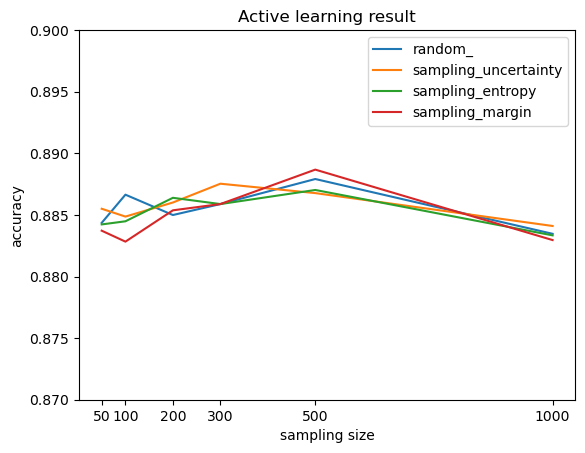

In [48]:
if args.eval_mode:
    for args.method in ["random", "sampling"]:
        sampling_size_list = [50, 100, 200, 300, 500, 1000]
        if args.method == "random":
            heuristic_list = ["uncertainty"]
        else:
            heuristic_list = ["uncertainty", "entropy", "margin"]

        for args.sampling_heuristic in heuristic_list:
            sampling_y = []
            for args.sampling_size in sampling_size_list:
                save_model_folder = f"{args.method}_{args.sampling_heuristic}_{args.sampling_size}"
                sampling_y.append(result_save_dict[save_model_folder])

            if args.method == "random": args.sampling_heuristic=""
            plt.plot(sampling_size_list, sampling_y, label=f"{args.method}_{args.sampling_heuristic}")
plt.ylim(0.87, 0.9)
plt.legend()
plt.xticks(sampling_size_list)
plt.xlabel("sampling size")
plt.ylabel("accuracy")
plt.title("Active learning result")
